In [1]:
import numpy as np
import time

In [2]:
import data_create
import evaluation_plot
import LDA_collapsed_gibbs_sampling_Numba as CGS
import LDA_particle_filter

## 1.Create Data

In [3]:
X, X_words, y = data_create.create_data()

X: (documents, words)  (2054, 1775)


In [4]:
topic_num = 4
docu_num = X.shape[0]
word_num = X.shape[1]

## 2.Initial learning using 20% data by collapsed gibbs sampling

### (i)set parmeters and change data struction

In [5]:
# using 20% if all data 
docu_init_num = int(docu_num*0.2)
X_init = X[:docu_init_num]
y_init = y[:docu_init_num]
print('X_init: (documents, words) ',X_init.shape)

# make 1D words array assorting documents
word_init_index, docu_init_index = np.meshgrid(np.arange(word_num), np.arange(docu_init_num))
word_init_index = np.ravel(word_init_index)
docu_init_index = np.ravel(docu_init_index)
X_init_1D = np.ravel(X_init)
word_init_index = np.repeat(word_init_index, X_init_1D)
docu_init_index = np.repeat(docu_init_index, X_init_1D)

# topic initialization by randomize
topic_init = np.random.randint(low=0, high=topic_num, size=len(word_init_index))
topic_init_len = len(topic_init)

X_init: (documents, words)  (410, 1775)


In [6]:
# Dirichlet parameters

alpha=np.ones(topic_num)
beta=np.ones(word_num)
sum_beta = np.sum(beta)

In [7]:
# calc initial value of n_dk and n_kv
n_dk_init = CGS.count_n_dk_numba(docu_init_index, topic_init, docu_init_num, topic_num)
n_vk_init = CGS.count_n_kv_numba(word_init_index, topic_init, word_num, topic_num)
n_vk_beta_init_sum_axis0 = np.sum(n_vk_init, axis=0) + np.sum(beta)

print('n_dk_init: (document, topic) ',n_dk_init.shape)
print('n_vk_init: (words, topic) ',n_vk_init.shape)

n_dk_init: (document, topic)  (410, 4)
n_vk_init: (words, topic)  (1775, 4)


### (ii)Collapsed gibbs sampling

In [8]:
# Collapsed Gibbs Sampling
iter_num=100
start = time.time()
topic_init, n_dk_init, n_vk_init = CGS.collapsed_gibbs_sampling_numba(topic_init, topic_init_len, iter_num, n_dk_init, n_vk_init, docu_init_index, word_init_index, alpha, beta, sum_beta, n_vk_beta_init_sum_axis0)
end = time.time()-start
print(end)

0.922736406326294


### (iii)Frequent Words per inferenced topic

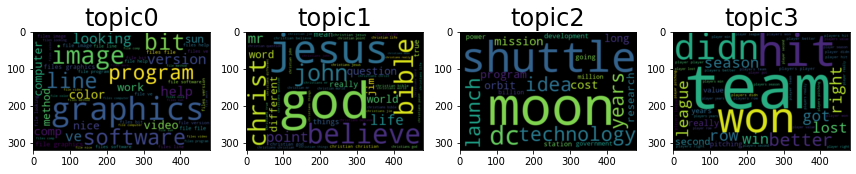

In [9]:
evaluation_plot.plot_wordcloud(n_vk_init, X_words, topic_num)

### (iv)Comparison between 'inferenced topic of documents' and 'true label(which news)'
#### colors represents true label

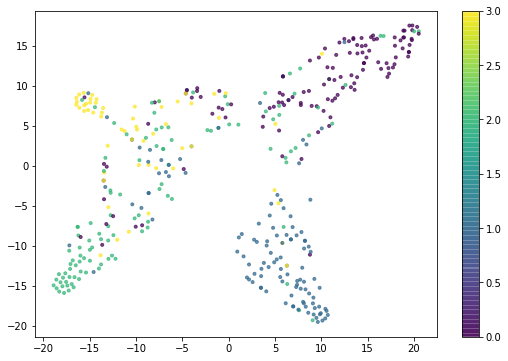

In [10]:
n_dk_init_for_evaluation =  n_dk_init/np.sum(n_dk_init, axis=1)[:, np.newaxis]
evaluation_plot.plot_tSNE_plot(n_dk_init_for_evaluation, y_init)

## 3.Particle Filter

### (i)set parmeters and change data structure

In [11]:
particle_num=100

# Dirichlet parameters

alpha = np.ones((topic_num,1))*0.1
beta = np.ones((word_num, topic_num,1))*0.1

In [12]:
# left data for PF
docu_PF_num = docu_num - docu_init_num

X_PF = X[docu_init_num:]
y_PF = y[docu_init_num:]
print('X_PF (document, word)', X_PF.shape)

word_PF_index, docu_PF_index = np.meshgrid(np.arange(word_num), np.arange(docu_PF_num))
word_PF_index = np.ravel(word_PF_index)
docu_PF_index = np.ravel(docu_PF_index)
X_PF_1D = np.ravel(X_PF)

word_PF_index = np.repeat(word_PF_index, X_PF_1D)
docu_PF_index = np.repeat(docu_PF_index, X_PF_1D)
PF_len = len(word_PF_index)

X_PF (document, word) (1644, 1775)


In [13]:
# iniherit init n_vk by CGS
n_vk_particles = np.repeat(n_vk_init[:, :, np.newaxis], particle_num, axis=2)
n_vk_beta_particles = n_vk_particles + beta

print('n_vk_particles: (words, topic, particles) ',n_vk_particles.shape)

n_vk_particles: (words, topic, particles)  (1775, 4, 100)


### (ii)Particle Filter

In [14]:
start = time.time()
n_dk_alpha_list, n_vk_beta_particles, w_list, w = LDA_particle_filter.Partilcle_Filter(particle_num, topic_num, PF_len, docu_PF_index, word_PF_index, n_vk_beta_particles, alpha, beta)
print(time.time()-start)

164.08200788497925


### (iii)Frequent Words per inferenced topic

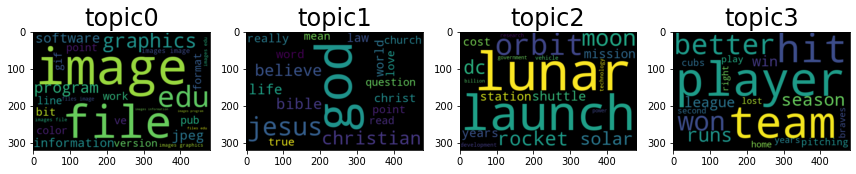

In [15]:
n_vk_particles = n_vk_beta_particles-beta
n_vk_weigted = np.mean(n_vk_particles*w[np.newaxis, np.newaxis,:], axis=2)

evaluation_plot.plot_wordcloud(n_vk_weigted, X_words, topic_num)

### (iv)Comparison between 'inferenced topic of documents' and 'true label(which news)'
#### colors represents true label

In [16]:
## weighted average
result_list = []
for n_dk_alpha_cond_d_particles, w in zip(n_dk_alpha_list, w_list):
    n_dk_cond_d_particles = n_dk_alpha_cond_d_particles-alpha
    n_dk_weigted = np.mean(n_dk_cond_d_particles * w[np.newaxis,:], axis=1)
    result_list.append(n_dk_weigted)
n_dk_alpha_PF = np.array(result_list)

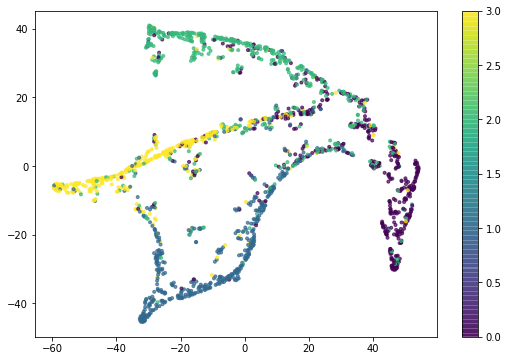

In [17]:
n_dk_alpha_PF_for_evaluation =  n_dk_alpha_PF/np.sum(n_dk_alpha_PF, axis=1)[:, np.newaxis]
evaluation_plot.plot_tSNE_plot(n_dk_alpha_PF_for_evaluation, y_PF)